### IMPORT LIBRARIES

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt

In [2]:
# read data 
data = pd.read_csv("../dataset/ADA-USD.csv")

In [3]:
data.head()

,timestamp,adjclose,open,high,volume,low,close
0,2017-11-09 00:00:00,0.032053,0.025160,0.035060,18716200,0.025006,0.032053
1,2017-11-10 00:00:00,0.027119,0.032219,0.033348,6766780,0.026451,0.027119
2,2017-11-11 00:00:00,0.027437,0.026891,0.029659,5532220,0.025684,0.027437
3,2017-11-12 00:00:00,0.023977,0.027480,0.027952,7280250,0.022591,0.023977
4,2017-11-13 00:00:00,0.025808,0.024364,0.026300,4419440,0.023495,0.025808


In [36]:
# data missing values
data.isna().sum()

timestamp    0
adjclose     0
open         0
high         0
volume       0
low          0
close        0
dtype: int64

In [8]:
data.dtypes

timestamp     object
adjclose     float64
open         float64
high         float64
volume         int64
low          float64
close        float64
dtype: object

In [10]:
data.describe()

,adjclose,open,high,volume,low,close
count,1785.000000,1785.000000,1785.000000,1.785000e+03,1785.000000,1785.000000
mean,0.497957,0.497727,0.519658,1.182721e+09,0.474308,0.497957
std,0.639482,0.639499,0.666564,2.091185e+09,0.610667,0.639482
min,0.023961,0.023954,0.025993,2.930550e+06,0.019130,0.023961
25%,0.059944,0.059938,0.061975,7.303750e+07,0.057984,0.059944
50%,0.142695,0.142591,0.147619,2.535122e+08,0.137262,0.142695
75%,0.805043,0.805056,0.852062,1.291715e+09,0.781908,0.805043
max,2.968239,2.966390,3.099186,1.914198e+10,2.907606,2.968239


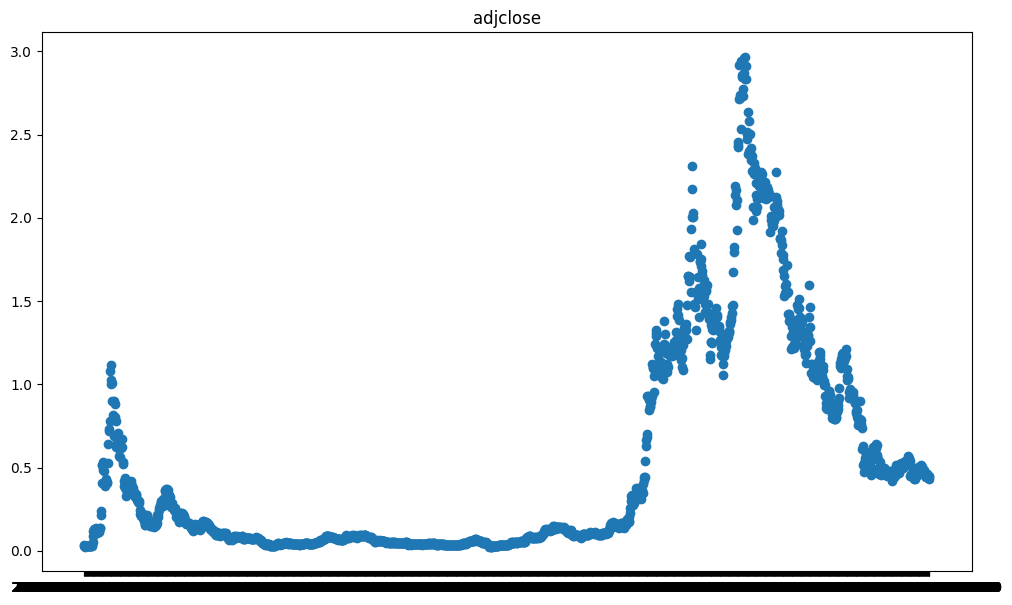

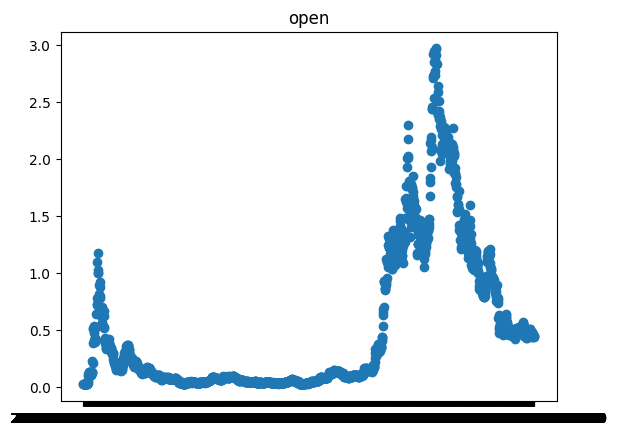

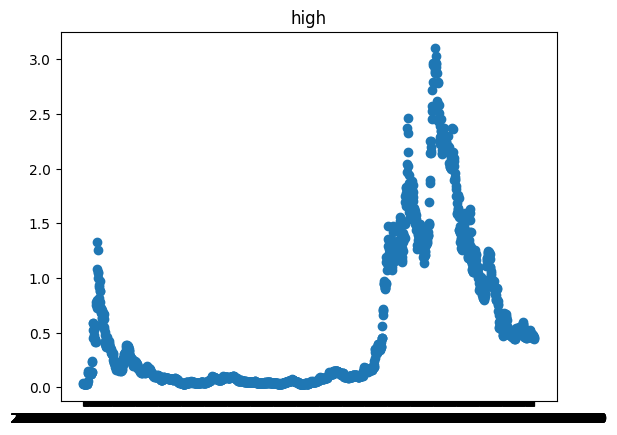

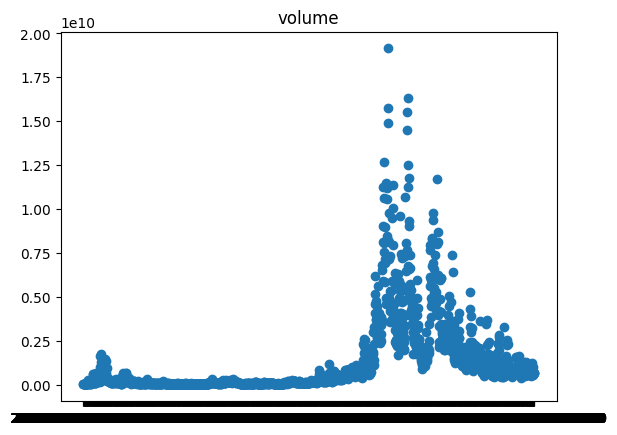

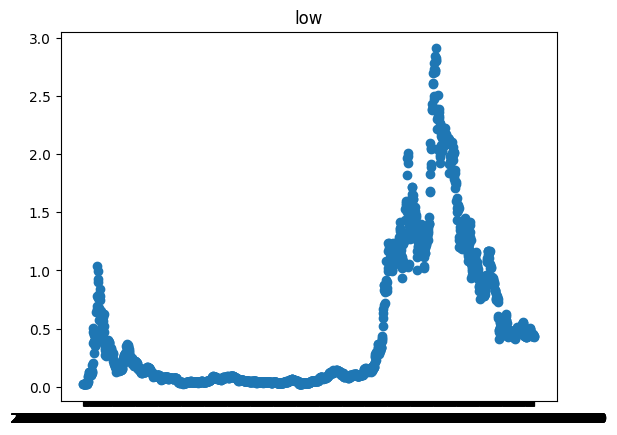

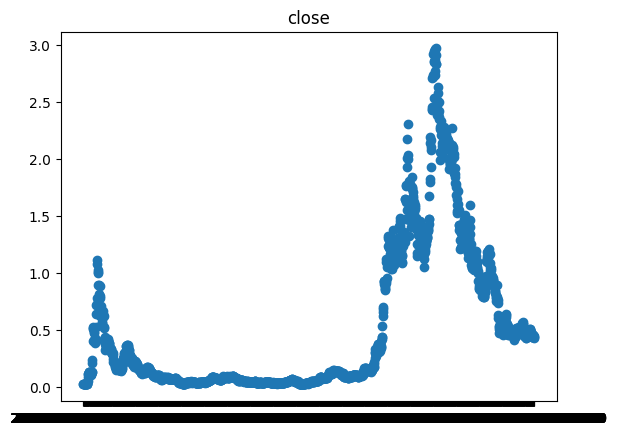

In [15]:
figure = plt.figure(figsize=(12, 7))
for i in data.describe().columns:
    plt.scatter(x=data.timestamp, y=data[i])
    plt.title("{}".format(i))
    plt.show()

In [21]:
heatmap_data = data.drop("timestamp", axis=1).corr()

In [22]:
import seaborn as sns

<Axes: >

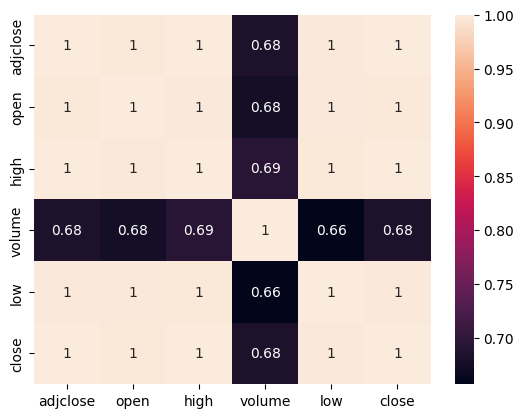

In [23]:
sns.heatmap(heatmap_data, annot=True)

In [24]:
# tim stamp parsing
df = data.copy()

In [25]:
df.timestamp = pd.to_datetime(df.timestamp)

In [27]:
df = df.set_index("timestamp")

In [28]:
df.head()

,adjclose,open,high,volume,low,close
timestamp,,,,,,
2017-11-09,0.032053,0.025160,0.035060,18716200,0.025006,0.032053
2017-11-10,0.027119,0.032219,0.033348,6766780,0.026451,0.027119
2017-11-11,0.027437,0.026891,0.029659,5532220,0.025684,0.027437
2017-11-12,0.023977,0.027480,0.027952,7280250,0.022591,0.023977
2017-11-13,0.025808,0.024364,0.026300,4419440,0.023495,0.025808


In [43]:
## Manuel train test split

In [29]:
train_size = int(len(df)*0.8)
test_size = int(len(df)-train_size)

In [30]:
test_size, train_size

(357, 1428)

In [31]:
data_to_train_test = np.array(data["close"].values)

In [32]:
data_to_train_test

array([0.032053  , 0.027119  , 0.027437  , ..., 0.44675699, 0.44189   ,
       0.4296076 ])

In [37]:
def train_test_split(dataframe, window_size: int) -> np.array:
    x = []
    y = []

    for i in range(len(dataframe)-window_size):

        row = [[j] for j in dataframe[i:i+window_size]]
        lab = dataframe[i+window_size]

        x.append(row)
        y.append(lab)

    return np.array(x), np.array(y)

In [95]:
X, y = train_test_split(data_to_train_test, window_size=30)

In [96]:
X.shape

(1755, 30, 1)

In [97]:
y.shape

(1755,)

In [98]:
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

In [99]:
X_train.shape, y_train.shape

((1428, 30, 1), (1428,))

### CREATE ANN

In [51]:
from keras.layers import SimpleRNN, Dense, InputLayer
from keras.models import Sequential
from keras.metrics import R2Score
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [100]:
model = Sequential()
model.add(InputLayer((30, 1)))
model.add(SimpleRNN(units=60, activation="tanh"))
model.add(Dense(1))

model.compile(loss="mse", optimizer="adam", metrics=[R2Score()])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 60)                3720      
                                                                 
 dense_5 (Dense)             (None, 1)                 61        
                                                                 
Total params: 3781 (14.77 KB)
Trainable params: 3781 (14.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [101]:
ealy_stop = EarlyStopping(monitor="loss", patience=25, start_from_epoch=80)
cp = ModelCheckpoint(save_weights_only=True, save_best_only=True, filepath="../models/ada_model")

In [102]:
model.fit(X_train, y_train, epochs=200, batch_size=64, callbacks=[ealy_stop, cp], validation_split=0.1)

Epoch 1/200
21/21 [==============================] - 1s 14ms/step - loss: 0.0309 - r2_score: 0.8031 - val_loss: 0.2208 - val_r2_score: 0.2401
Epoch 2/200
21/21 [==============================] - 0s 9ms/step - loss: 0.0053 - r2_score: 0.9659 - val_loss: 0.1066 - val_r2_score: 0.6332
Epoch 3/200
21/21 [==============================] - 0s 8ms/step - loss: 0.0043 - r2_score: 0.9726 - val_loss: 0.0739 - val_r2_score: 0.7458
Epoch 4/200
21/21 [==============================] - 0s 9ms/step - loss: 0.0049 - r2_score: 0.9688 - val_loss: 0.0865 - val_r2_score: 0.7023
Epoch 5/200
21/21 [==============================] - 0s 8ms/step - loss: 0.0031 - r2_score: 0.9803 - val_loss: 0.0661 - val_r2_score: 0.7725
Epoch 6/200
21/21 [==============================] - 0s 8ms/step - loss: 0.0027 - r2_score: 0.9825 - val_loss: 0.0520 - val_r2_score: 0.8209
Epoch 7/200
21/21 [==============================] - 0s 8ms/step - loss: 0.0027 - r2_score: 0.9825 - val_loss: 0.0584 - val_r2_score: 0.7991
Epoch 8/200


In [105]:
predicted = model.predict(X_test)

11/11 [==============================] - 0s 2ms/step


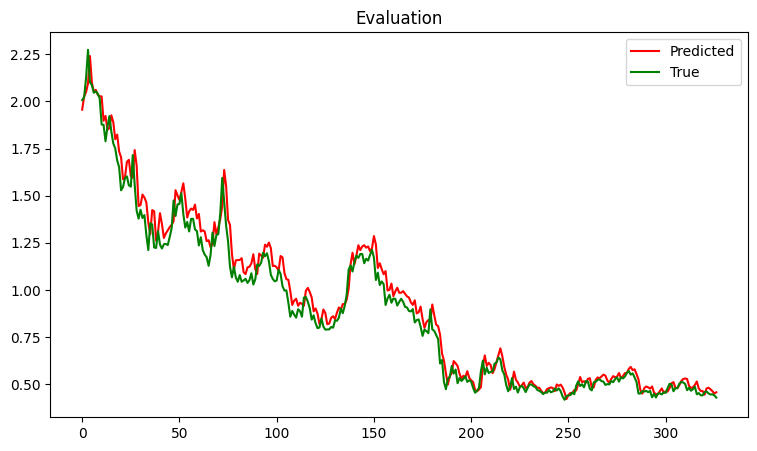

In [106]:
plt.figure(figsize=(9,5))
plt.title("Evaluation")
plt.plot(predicted, color="r", label="Predicted")
plt.plot(y_test, color="g", label="True")
plt.legend()
plt.show()